In [15]:
import pyzx as zx
import random
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumCircuit, ParameterVector
import csv
import time
from typing import List,Dict,Set

In [16]:
def generate_H_S_CNOT_T_circuit(qubits, gates, p_t=0, seed=1000):
    random.seed(seed)  
    p_s = 0.333 * (1.0 - p_t)  
    p_had = 0.333 * (1.0 - p_t)  
    p_cnot = 0.333 * (1.0 - p_t)  

    c = zx.Circuit(qubits) 
    for _ in range(gates):
        r = random.random() 
        if r < p_had:
            c.add_gate("HAD", random.randrange(qubits))
        elif r < p_had + p_s:
            c.add_gate("S", random.randrange(qubits))
        elif r < p_had + p_s + p_t:
            c.add_gate("T", random.randrange(qubits))
        else:
            tgt = random.randrange(qubits)
            while True:
                ctrl = random.randrange(qubits)
                if ctrl != tgt:
                    break
            c.add_gate("CNOT", tgt, ctrl)
    return c



Circuit  on 4 qubits with 50 gates.
        10 is the T-count
        40 Cliffords among which
        16 2-qubit gates (16 CNOT, 0 other) and
        15 Hadamard gates.
Circuit  on 4 qubits with 41 gates.
        10 is the T-count
        31 Cliffords among which
        15 2-qubit gates (12 CNOT, 3 other) and
        9 Hadamard gates.


Graph(23 vertices, 47 edges)
degree distribution: 
1: 9
3: 2
4: 2
6: 5
7: 2
9: 3

H count 42 normal count 5
jisaku degree {1: 9, 3: 2, 4: 2, 6: 5, 7: 2, 9: 3}
phase count 13
This function is deprecated. Call extract_circuit() instead.
Circuit  on 4 qubits with 53 gates.
        10 is the T-count
        43 Cliffords among which
        22 2-qubit gates (5 CNOT, 17 other) and
        18 Hadamard gates.


gate_count OrderedDict([('h', 18), ('cz', 17), ('rz', 13), ('cx', 5)])


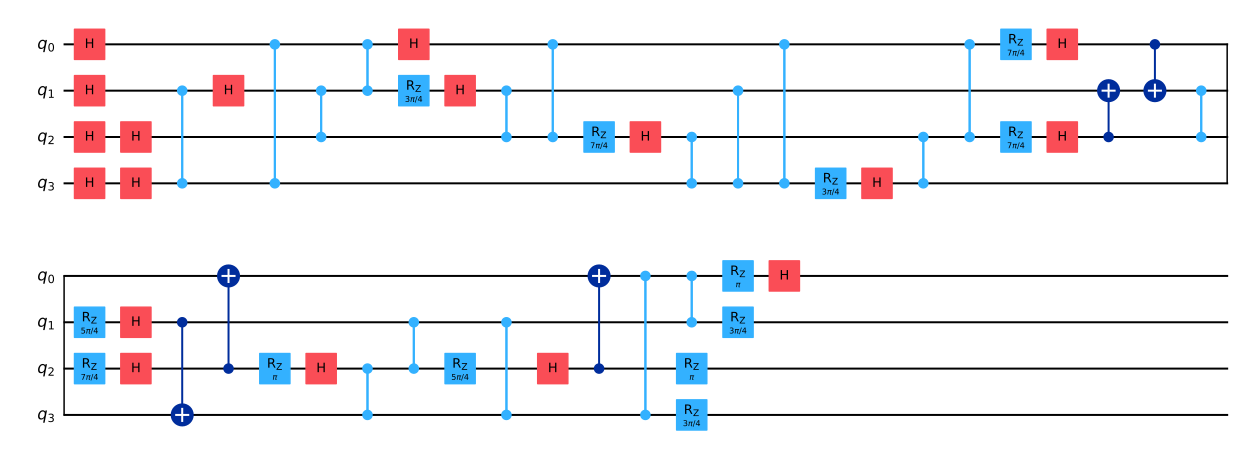

In [17]:
c = generate_H_S_CNOT_T_circuit(4,gates=50,p_t=0.24, seed = 53)
print(c.stats())
c = zx.optimize.basic_optimization(c)
print(c.stats())

g = c.to_graph()
zx.draw(g)


zx.simplify.clifford_simp(g)
zx.draw(g)
print(g.stats())

#edge count
H_edge_count = 0
normal_edge_count = 0
for v0,adj in g.graph.items():
    for v1 in adj:
        if v1 > v0:
            if g.edge_type((v0,v1)) == 2:
                H_edge_count += 1
            else:
                normal_edge_count += 1
print("H count" ,H_edge_count , "normal count", normal_edge_count)

#degree
degrees: dict[int,int] = {}
for v in g.vertices():
    d = g.vertex_degree(v)
    if d in degrees:
        degrees[d] += 1
    else:
        degrees[d] = 1
    degrees = dict(sorted(degrees.items()))
print("jisaku degree",degrees)

#phase_count
phase_count = 0
for v in g.vertices():
    if g.phase(v) != 0:
        phase_count += 1
print("phase count", phase_count)

c = zx.extract.streaming_extract(g)
#c = zx.optimize.basic_optimization(c)
print(c.stats())
zx.draw(c)

circuit_qiskit = QuantumCircuit.from_qasm_str(c.to_basic_gates().to_qasm())

print("gate_count", circuit_qiskit.count_ops())
circuit_qiskit.draw('mpl')

In [18]:
c = generate_H_S_CNOT_T_circuit(4,gates=100,p_t=0.5, seed = 1000)
print(c.stats())
c = zx.optimize.basic_optimization(c)
print(c.stats())

g = c.to_graph()


zx.simplify.clifford_simp(g)

#graph から　H edgeの数を数える

print(g.stats())
zx.draw(g)
H_edge_count = 0
for v0,adj in g.graph.items():
    for v1 in adj:
        if v1 > v0:
            if g.edge_type((v0,v1)) == 2:
                H_edge_count += 1
print("H count" ,H_edge_count)

Circuit  on 4 qubits with 100 gates.
        52 is the T-count
        48 Cliffords among which
        17 2-qubit gates (17 CNOT, 0 other) and
        15 Hadamard gates.
Circuit  on 4 qubits with 44 gates.
        6 is the T-count
        38 Cliffords among which
        19 2-qubit gates (17 CNOT, 2 other) and
        9 Hadamard gates.
Graph(21 vertices, 34 edges)
degree distribution: 
1: 8
3: 4
4: 2
5: 3
6: 3
7: 1



H count 28


In [19]:
qubits_list = [4,8,12,16]
p_t_lists = [0,0.04,0.08,0.12,0.16,0.20,0.40]
gate_num_lists =[500,1000,5000,10000]
seeds = [1000,1001,1002]

output_file = "../kekka0107/0107bunpu.csv"
fieldnames = fieldnames = [
    "optimize_name","data_name","qubit","input_gates","p_t","seed",
    "gates_aft","one-qubit_gates","two-qubit_gates","H_edge count",
    "0","5","10","15","20","25","30","35","40","45","50","55","60","65","70","75","80","85","90","95","100","101"
]

with open(output_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for qubit in qubits_list:
        for gate_num in gate_num_lists:
            for p_t in p_t_lists:
                for seed in seeds:
                    try:
                        start = time.time()
                        # 回路作成
                        c = generate_H_S_CNOT_T_circuit(qubits = qubit,gates= gate_num,p_t = p_t,seed = seed)
                        c = zx.optimize.basic_optimization(c)
                        g = c.to_graph()
                        zx.simplify.clifford_simp(g)
                        
                        #degree
                        degrees: dict[int,int] = {}
                        #0,5,10,15,20,25,30,35,40,45,50,...,100
                        degrees = {i:0 for i in range(0,101,5)}
                        degrees[101] = 0

                        for v in g.vertices():
                            d = g.vertex_degree(v)
                            if d <= 100:
                                degrees[d - d % 5] += 1
                            elif d > 100:
                                degrees[101] += 1
                            else:
                                print("error")                        
                            degrees = dict(sorted(degrees.items()))
                        print("jisaku degree",degrees)

                        H_edge_count = 0
                        for v0,adj in g.graph.items():
                            for v1 in adj:
                                if v1 > v0:
                                    if g.edge_type((v0,v1)) == 2:
                                        H_edge_count += 1

                        c = zx.extract.streaming_extract(g)
                        end = time.time()

                        optimize_name = "clifford_simp_notaft_basic"
                        dataname = "q" + str(qubit) + "_gates" + str(gate_num) + "_pt" +str(p_t)+ "_seeds" + str(seed)

                        #qiskit変換とカウント
                        circuit_qiskit = QuantumCircuit.from_qasm_str(c.to_basic_gates().to_qasm())
                        depth = circuit_qiskit.depth()
                        zx_dict = c.to_basic_gates().stats_dict()
                        qiskit_dict = circuit_qiskit.count_ops()

                        optimize_name = "clifford_simp_not_post_basic"
                        gates_aft = zx_dict["gates"]


                        # 結果をCSVに書き込む
                        writer.writerow({
                            "optimize_name": optimize_name,
                            "data_name": dataname,
                            "qubit": qubit,
                            "gates_aft": gates_aft,
                            "one-qubit_gates": gates_aft - qiskit_dict.get("cx", 0) - qiskit_dict.get("cz", 0),
                            "two-qubit_gates": qiskit_dict.get("cx", 0) + qiskit_dict.get("cz", 0),
                            "H_edge count": H_edge_count,
                            "input_gates": gate_num,
                            "p_t": p_t,
                            "seed": seed,

                            **{str(k): v for k, v in degrees.items()}
                        })

                        print(f"done. Qubits={qubit}, Gate_Num={gate_num}, P_T={p_t},seed={seed},time={end-start}")

                    except Exception as e:
                        print(f"Error for Qubits={qubit}, Gate_Num={gate_num}, P_T={p_t}: {e}")



jisaku degree {0: 12, 5: 4, 10: 0, 15: 0, 20: 0, 25: 0, 30: 0, 35: 0, 40: 0, 45: 0, 50: 0, 55: 0, 60: 0, 65: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 95: 0, 100: 0, 101: 0}
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=500, P_T=0,seed=1000,time=0.03717374801635742
jisaku degree {0: 12, 5: 4, 10: 0, 15: 0, 20: 0, 25: 0, 30: 0, 35: 0, 40: 0, 45: 0, 50: 0, 55: 0, 60: 0, 65: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 95: 0, 100: 0, 101: 0}
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=500, P_T=0,seed=1001,time=0.025841474533081055
jisaku degree {0: 14, 5: 2, 10: 0, 15: 0, 20: 0, 25: 0, 30: 0, 35: 0, 40: 0, 45: 0, 50: 0, 55: 0, 60: 0, 65: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 95: 0, 100: 0, 101: 0}
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=500, P_T=0,seed=1002,time=0.02684950828552246
jisaku degree {0: 10, 5: 8, 10: 7, 15: 7, 20: 0, 25: 0, 30: 0, 35: 0, 40: 0, 45: 0, 50: 0, 55

KeyboardInterrupt: 

In [22]:
qubits_list = [4,8,12,16]
p_t_lists = [0,0.04,0.08,0.12,0.16,0.20,0.40]
gate_num_lists =[500,1000,5000,10000]
seeds = [1000,1001,1002]

output_file = "../kekka0107/0107bunpu.csv"
fieldnames = fieldnames = [
    "optimize_name","data_name","qubit","input_gates","p_t","seed",
    "gates_aft","one-qubit_gates","two-qubit_gates","edge count","spider count",
    "0","5","10","15","20","25","30","35","40","45","50","55","60","65","70","75","80","85","90","95","100",
    "105","110","115","120","125","130","135","140","145","150","155","160","165","170","175","180","185","190","195","200","205"
]

with open(output_file, "w", newline="", encoding="utf-8") as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    for qubit in qubits_list:
        for gate_num in gate_num_lists:
            for p_t in p_t_lists:
                for seed in seeds:
                    try:
                        start = time.time()
                        # 回路作成
                        c = generate_H_S_CNOT_T_circuit(qubits = qubit,gates= gate_num,p_t = p_t,seed = seed)
                        c = zx.optimize.basic_optimization(c)
                        g = c.to_graph()
                        zx.simplify.clifford_simp(g)
                        
                        #degree
                        degrees: dict[int,int] = {}
                        degrees = {i:0 for i in range(0,206,5)}
                        spider_count = 0

                        for v in g.vertices():
                            spider_count += 1
                            d = g.vertex_degree(v)
                            if d <= 205:
                                degrees[d - d % 5] += 1
                            elif d > 100:
                                degrees[205] += 1
                            else:
                                print("error")                        
                            degrees = dict(sorted(degrees.items()))
                        print("jisaku degree",degrees)

                        edge_count = 0
                        for v0,adj in g.graph.items():
                            for v1 in adj:
                                if v1 > v0:
                                    edge_count += 1

                        c = zx.extract.streaming_extract(g)
                        end = time.time()

                        optimize_name = "clifford_simp_notaft_basic"
                        dataname = "q" + str(qubit) + "_gates" + str(gate_num) + "_pt" +str(p_t)+ "_seeds" + str(seed)

                        #qiskit変換とカウント
                        circuit_qiskit = QuantumCircuit.from_qasm_str(c.to_basic_gates().to_qasm())
                        depth = circuit_qiskit.depth()
                        zx_dict = c.to_basic_gates().stats_dict()
                        qiskit_dict = circuit_qiskit.count_ops()

                        optimize_name = "clifford_simp_not_post_basic"
                        gates_aft = zx_dict["gates"]


                        # 結果をCSVに書き込む
                        writer.writerow({
                            "optimize_name": optimize_name,
                            "data_name": dataname,
                            "qubit": qubit,
                            "gates_aft": gates_aft,
                            "one-qubit_gates": gates_aft - qiskit_dict.get("cx", 0) - qiskit_dict.get("cz", 0),
                            "two-qubit_gates": qiskit_dict.get("cx", 0) + qiskit_dict.get("cz", 0),
                            "edge count": edge_count,
                            "spider count": spider_count,
                            "input_gates": gate_num,
                            "p_t": p_t,
                            "seed": seed,

                            **{str(k): v for k, v in degrees.items()}
                        })

                        print(f"done. Qubits={qubit}, Gate_Num={gate_num}, P_T={p_t},seed={seed},time={end-start}")

                    except Exception as e:
                        print(f"Error for Qubits={qubit}, Gate_Num={gate_num}, P_T={p_t}: {e}")



jisaku degree {0: 12, 5: 4, 10: 0, 15: 0, 20: 0, 25: 0, 30: 0, 35: 0, 40: 0, 45: 0, 50: 0, 55: 0, 60: 0, 65: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 95: 0, 100: 0, 105: 0, 110: 0, 115: 0, 120: 0, 125: 0, 130: 0, 135: 0, 140: 0, 145: 0, 150: 0, 155: 0, 160: 0, 165: 0, 170: 0, 175: 0, 180: 0, 185: 0, 190: 0, 195: 0, 200: 0, 205: 0}
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=500, P_T=0,seed=1000,time=0.03413128852844238
jisaku degree {0: 12, 5: 4, 10: 0, 15: 0, 20: 0, 25: 0, 30: 0, 35: 0, 40: 0, 45: 0, 50: 0, 55: 0, 60: 0, 65: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 95: 0, 100: 0, 105: 0, 110: 0, 115: 0, 120: 0, 125: 0, 130: 0, 135: 0, 140: 0, 145: 0, 150: 0, 155: 0, 160: 0, 165: 0, 170: 0, 175: 0, 180: 0, 185: 0, 190: 0, 195: 0, 200: 0, 205: 0}
This function is deprecated. Call extract_circuit() instead.
done. Qubits=4, Gate_Num=500, P_T=0,seed=1001,time=0.024755239486694336
jisaku degree {0: 14, 5: 2, 10: 0, 15: 0, 20: 0, 25: 0, 30: 0, 35: 0, 40: 0

In [21]:
degrees: dict[int,int] = {}
degrees = {i:0 for i in range(0,206,5)}
print(degrees)

{0: 0, 5: 0, 10: 0, 15: 0, 20: 0, 25: 0, 30: 0, 35: 0, 40: 0, 45: 0, 50: 0, 55: 0, 60: 0, 65: 0, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0, 95: 0, 100: 0, 105: 0, 110: 0, 115: 0, 120: 0, 125: 0, 130: 0, 135: 0, 140: 0, 145: 0, 150: 0, 155: 0, 160: 0, 165: 0, 170: 0, 175: 0, 180: 0, 185: 0, 190: 0, 195: 0, 200: 0, 205: 0}
